## Create Dataset

In [1]:
import torch
import random
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data_utils
from model import Transformer,TCN,LSTMWithInputCellAttention,LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
train_set = datasets.MNIST('./data', train=True, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                            ]))
test_set = datasets.MNIST('./data', train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ]))

In [3]:
def mix(i,j,dataset):
  ret = torch.zeros_like(dataset.data[i], dtype=torch.float)
  ret[:, torch.arange(0, 28, 2)] = dataset.data[i][:, torch.arange(0, 28, 2)].float()
  ret[:, torch.arange(0, 28, 2) + 1] = dataset.data[j][:, torch.arange(0, 28, 2) + 1].float()

  return ret

In [4]:
def data_generator_random(batch_size,returnSet=False):
    train_set = datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.MNIST('./data', train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))
    
    new_train_data = []       # mixed image
    new_train_targets = []    # even column label (0 based)
    new_train_noise = []      # odd column label  (0 based)
    id1 = []
    for i in range(0,10):
      id1.append([id for id, e in enumerate(train_set.targets) if e == i])
    repeat = 2
    for t in range(0,10):   # targets
      for i in id1[t]:   
        for num in range(repeat):
          noise = random.randint(0, 9)
          while noise == t:
            noise = random.randint(0, 9)
          noise_idx = random.sample(id1[noise], 1)[0]
          new_train_data.append(mix(i,noise_idx,train_set))
          new_train_targets.append(t)
      new_train_noise.append(noise)
    
    new_test_data = []       # mixed image
    new_test_targets = []    # even column label (0 based)
    new_test_noise = []      # odd column label  (0 based)

    id2 = []
    for i in range(0,10):
      id2.append([id for id, e in enumerate(test_set.targets) if e == i])
    repeat = 2
    for t in range(0,10):   # targets
      for i in id2[t]:   
        for num in range(repeat):
          noise = random.randint(0, 9)
          while noise == t:
            noise = random.randint(0, 9)
          noise_idx = random.sample(id2[noise], 1)[0]
          new_test_data.append(mix(i,noise_idx, test_set))
          new_test_targets.append(t)
          new_test_noise.append(noise)
    
    new_train_data = torch.stack((new_train_data))
    new_train_data -= new_train_data.min(1, keepdim=True)[0]
    new_train_data /= new_train_data.max(1, keepdim=True)[0]
    new_train_data = torch.nan_to_num(new_train_data, nan=0.0)

    arr = np.array(new_train_targets)
    t = torch.from_numpy(arr)
    mnist_train = data_utils.TensorDataset(new_train_data,t)

    new_test_data = torch.stack((new_test_data))
    new_test_data -= new_test_data.min(1, keepdim=True)[0]
    new_test_data /= new_test_data.max(1, keepdim=True)[0]
    new_test_data = torch.nan_to_num(new_test_data, nan=0.0)

    arr2 = np.array(new_test_targets)
    t2 = torch.from_numpy(arr2)
    minst_test = data_utils.TensorDataset(new_test_data,t2)
    
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(minst_test, batch_size=batch_size)  
    
    if(returnSet):
      return train_set, test_set
    return train_loader, test_loader

## Define Transformer

In [ ]:
import torch.nn.functional as F
from torch import nn
from typing import *
from torch.nn import Parameter
from torch.autograd import Variable
import copy
import math
import torch
from torch.nn.utils import weight_norm

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

def attention(q, k, v, d_k, mask=None, dropout=None,returnWeights=False):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
    output = torch.matmul(scores, v)
    # print("Scores in attention itself",torch.sum(scores))
    if(returnWeights):
        return output,scores

    return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None,returnWeights=False):
        
        bs = q.size(0)
        
        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next

        if(returnWeights):
            scores,weights = attention(q, k, v, self.d_k, mask, self.dropout,returnWeights=returnWeights)
            # print("scores",scores.shape,"weights",weights.shape)
        else:
            scores = attention(q, k, v, self.d_k, mask, self.dropout)

        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        output = self.out(concat)
        # print("Attention output", output.shape,torch.min(output))
        if(returnWeights):
            return output,weights
        else:
            return output

In [ ]:
# Fine tune d_ff, dropout

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=448, dropout = 0.2):
        super().__init__() 
    
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model)
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x,returnWeights=False):
        if(returnWeights):
            attenOutput,attenWeights= self.attn(x,x,x,returnWeights=returnWeights)
        else:
            attenOutput= self.attn(x,x,x)
        x = x + self.dropout_1(attenOutput)
        y = self.norm_2(x)
        out = y + self.dropout_2(self.ff(y))
        if(returnWeights):
            return out,attenWeights
        else:
            return out

In [ ]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size,seq_len, N, heads, dropout):
        super().__init__()
        self.N = N
#         self.pe = PositionalEncoder(input_size,seq_len, dropout=dropout)
        self.layers = get_clones(EncoderLayer(input_size, heads, dropout), N)
        self.norm = Norm(input_size)
    def forward(self, x,returnWeights=False):
#         x = self.pe(x)
        for i in range(self.N):
            if(i==0 and returnWeights):
                x,weights = self.layers[i](x,returnWeights=returnWeights)
            else:
                x = self.layers[i](x)

        if(returnWeights):
            return self.norm(x),weights
        else:
            return self.norm(x)

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 100, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)

        pe = Variable(self.pe[:,:seq_len], requires_grad=False)

        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_size, seq_len, N, heads, dropout, num_classes, time=100):
        super().__init__()
        
        self.pe = PositionalEncoder(input_size,seq_len, dropout)
        
        self.encoder = Encoder(input_size,seq_len, N, heads, dropout)
        self.out = nn.Linear(input_size, num_classes) 
        self.tempmaxpool = nn.MaxPool1d(time)
        
    def forward(self, src, returnWeights=False):
        src = self.pe(src)
        src= src.transpose(1, 2)
        if(returnWeights):
            e_outputs,weights = self.encoder(src,returnWeights=returnWeights)
        else:
            e_outputs = self.encoder(src)

        e_outputs=self.tempmaxpool(e_outputs.transpose(1, 2)).squeeze(-1)
        output = self.out(e_outputs)
        output = F.softmax(output, dim=1)
        if(returnWeights):
            return output,weights
        else:
            return output

## Train

Reference https://github.com/ayaabdelsalam91/TS-Interpretability-Benchmark

Tunable Parameters:
1. \# of encoder layer
2. \# of hidden unit in positional encoding
3. \# of hidden unit in encoder MLP
4. Dropout rate

### Try deep network with higher dropout

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
def train(ep,model,train_loader,optimizer, ls):

  train_loss = 0
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)

      data = data.view(-1, 28, 28)
      data, target = Variable(data), Variable(target)
      optimizer.zero_grad()
      output = model(data)
      loss = ls(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss
      if batch_idx > 0 and batch_idx % 100 == 0:
          message = ('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              ep, batch_idx * 128, len(train_loader.dataset),
              100. * batch_idx / len(train_loader), train_loss.item()/100))
          print(message)
          train_loss = 0
  return model, optimizer

In [ ]:
def test(model,test_loader,ls):
  model.eval()
  test_loss = 0
  correct = 0
  Acc=0
  with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28, 28)
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += ls(output, target)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    Acc = 100. * correct / len(test_loader.dataset)
    message = ('\nTest set: Average loss: {:.10f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),Acc))
    print(message)

    return test_loss,Acc

In [ ]:
train_loader, test_loader = data_generator_random_0_2(128)

In [ ]:
ep = 2
dropout = 0.1
layer = 12
decay = 0.001
lr = 0.0005

model = Transformer(28, 28, layer, 4, dropout, 10,time=28)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = decay)
loss = nn.CrossEntropyLoss()

for epoch in range(1, ep+1):
  model,optimizer = train(epoch,model,train_loader,optimizer,loss)
  test_loss,test_acc = test(model,test_loader,loss)

Train Epoch: 1 [12800/118810 (11%)]	Loss: 0.525238
Train Epoch: 1 [25600/118810 (22%)]	Loss: 0.407589
Train Epoch: 1 [38400/118810 (32%)]	Loss: 0.374858
Train Epoch: 1 [51200/118810 (43%)]	Loss: 0.365789
Train Epoch: 1 [64000/118810 (54%)]	Loss: 0.359361
Train Epoch: 1 [76800/118810 (65%)]	Loss: 0.348769
Train Epoch: 1 [89600/118810 (75%)]	Loss: 0.350855
Train Epoch: 1 [102400/118810 (86%)]	Loss: 0.345109
Train Epoch: 1 [115200/118810 (97%)]	Loss: 0.342503

Test set: Average loss: 0.0025730222, Accuracy: 19839/20120 (98.60%)

Train Epoch: 2 [12800/118810 (11%)]	Loss: 0.345887
Train Epoch: 2 [25600/118810 (22%)]	Loss: 0.337004
Train Epoch: 2 [38400/118810 (32%)]	Loss: 0.339536
Train Epoch: 2 [51200/118810 (43%)]	Loss: 0.336598
Train Epoch: 2 [64000/118810 (54%)]	Loss: 0.337952
Train Epoch: 2 [76800/118810 (65%)]	Loss: 0.336491
Train Epoch: 2 [89600/118810 (75%)]	Loss: 0.338842
Train Epoch: 2 [102400/118810 (86%)]	Loss: 0.333091
Train Epoch: 2 [115200/118810 (97%)]	Loss: 0.332555

Test s

## PGD Attack

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from model import Transformer,TCN,LSTMWithInputCellAttention,LSTM

model = torch.load(open('./m_model_Transformer_NumClasses_10.pt', 'rb'), map_location=device)

In [7]:
train_loader, test_loader = data_generator_random(256)

In [87]:
def attack(model, images, labels, device, noise = -1, att_col=[], att_row=[], cols=[],
           eps = 0.05, alpha= 2/255, steps=40):
    if len(images.shape) < 3:
        images = images.unsqueeze(0)
        labels = labels.unsqueeze(0)
        if noise != -1:
            noise = noise.unsqueeze(0)
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    num_images = images.shape[0]

    outputs = model(images)

    loss = nn.NLLLoss()

    # Calculate orginal loss
    old_loss = loss(outputs, labels)

    adv_images = images.clone().detach()

    for _ in range(steps):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        _, pred = torch.max(outputs, 1)
            
        if noise == -1:
            cost = loss(outputs, labels)
        else:
            cost = -loss(outputs, noise)

        # Update adversarial images
        full_grad = torch.autograd.grad(cost, adv_images,
                                        retain_graph=False, create_graph=False)[0]

        grad = torch.zeros_like(full_grad)

        for i in range(num_images):
            if len(att_row) == 0:  # Attacking att_col
                for c in att_col:
                    grad[i, :, c] = full_grad[i, :, c]
            else:  # Attacking att_col[0], att_row = [...]
                grad = full_grad.clone().detach()
                for c in range(28):
                    if c not in cols:
                        grad[i,:,c] = 0
                for r in att_row:
                    grad[i,r,att_col[0]] = 0

        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()

    outputs = model(adv_images)
    new_loss = loss(outputs, labels)

    if len(att_row) == 0:
        return adv_images, (new_loss - old_loss)/(28*len(att_col))
    else:
        return adv_images, (new_loss - old_loss)/(28*len(cols)-len(att_row))

In [207]:
images, labels = next(iter(train_loader))

In [208]:
test_img = images[0]

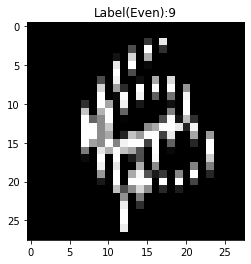

In [209]:
import matplotlib.pyplot as plt

plt.imshow(test_img, cmap='gray')
plt.title(f"Label(Even):{labels[0]}")
plt.show()

In [210]:
outputs = model(test_img.unsqueeze(0).to(device))
outputs

tensor([[-1.7346e+01, -1.8540e+01, -1.9702e+01, -1.2556e+01, -1.1539e+01,
         -1.5740e+01, -1.9408e+01, -1.1781e+01, -1.5580e+01, -2.1219e-05]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [22]:
def find_important_independent_colunms(model, image, label, noise, device, n_cols):
    scores = []
    for col in range(28):
        _, score = attack(model, image, label, device, noise, att_col=[col])
        scores.append((score.item(), col))
    scores.sort(reverse=True)
    cols = [c for _, c in scores[:n_cols]]
    best_scores = [s for s, _ in scores[:n_cols]]
    return cols, best_scores

In [54]:
def find_important_joint_colunms(model, image, label, noise, device, n_cols):
    available_cols = [i for i in range(28)]
    chosen_cols = []
    prev_best_score = float("-inf")
    scores = []
    label = torch.as_tensor(label).to(device)
    noise = torch.as_tensor(noise).to(device)
    for _ in range(n_cols):
        best_col = None
        best_score = float("-inf")
        for col in available_cols:
            _, score = attack(model, image, label, device, noise, att_col=chosen_cols+[col])
            score = score.item()
            if score > best_score:
                best_col = col
                best_score = score
        chosen_cols.append(best_col)
        available_cols.remove(best_col)
        if prev_best_score == float("-inf"):
            scores.append(best_score)
        else:
            scores.append(best_score - prev_best_score)
        prev_best_score = best_score

    return chosen_cols, scores

In [24]:
def find_important_rows(model, image, label, noise, device, cols, n_row):
    label = torch.as_tensor(label).to(device)
    noise = torch.as_tensor(noise).to(device)
    important_rows = []
    for col in cols:
        scores = []
        for row in range(28):
            _, score = attack(model, image, label, device, noise, att_col=[col], att_row=[row])
            scores.append((score.item(), row))
        scores.sort(reverse=True)
        best_rows = [r for _, r in scores[:n_row]]
        important_rows.append(best_rows)

    return important_rows

In [83]:
def find_important_joint_rows(model, image, label, noise, device, cols, n_rows):
    label = torch.as_tensor(label).to(device)
    noise = torch.as_tensor(noise).to(device)
    important_rows = []
    all_scores = []
    for col in cols:
        available_rows = [i for i in range(28)]
        chosen_rows = []
        prev_best_score = float('inf')
        scores = []
        for n_row in range(n_rows):
            best_row = None
            best_score = float('inf')
            for row in available_rows:
                _, score = attack(model, image, label, device, noise, att_col=[col], att_row = chosen_rows+[row], cols=cols)
                score = score.item()
                if score < best_score:
                    best_row = row
                    best_score = score
            chosen_rows.append(best_row)
            available_rows.remove(best_row)
            if prev_best_score == float("inf"):
                scores.append(best_score)
            else:
                scores.append(prev_best_score - best_score)
            prev_best_score = best_score
        important_rows.append(chosen_rows)
        all_scores.append(scores)

    return all_scores, important_rows

In [26]:
def find_pixels_from_column(model, image, label, noise, device, cols, n_pixels):
    label = torch.as_tensor(label).to(device)
    noise = torch.as_tensor(noise).to(device)
    prev_best_score = float("inf")
    pixels = []
    for _ in range(n_pixels):
        best_score = float("inf")
        best_pixel = None
        for row in range(28):
            for col in cols:
                tup = (row,col)
                if tup not in pixels:
                    _, score = attack_pixel(model, image, label, device, noise, cols = cols, pixels=pixels+[tup])
                    if score < best_score:
                        best_score = score
                        best_pixel = tup
        pixels.append(best_pixel)
        prev_best_score = best_score
    return pixels

In [211]:
cols, score = find_important_joint_colunms(model, test_img, 9, 6, device, 8)

In [212]:
cols, score

([16, 18, 14, 21, 11, 20, 15, 10],
 [5.662276407747413e-07,
  4.980867061021854e-07,
  8.91365016286727e-06,
  5.020971002522856e-05,
  8.417852950515226e-05,
  0.006356006459100172,
  0.015264488756656647,
  0.012163525447249413])

In [213]:
s, r = find_important_joint_rows(model, test_img, 9, 6, device, [16, 18, 14, 21, 11, 20, 15, 10], 8)

In [215]:
r

[[0, 1, 16, 12, 23, 2, 25, 17],
 [1, 3, 18, 19, 16, 22, 7, 20],
 [26, 6, 5, 12, 2, 24, 0, 23],
 [3, 27, 23, 10, 0, 24, 7, 26],
 [0, 26, 19, 22, 24, 5, 16, 23],
 [1, 26, 8, 14, 21, 0, 3, 5],
 [0, 20, 5, 6, 9, 17, 24, 25],
 [13, 20, 27, 10, 12, 25, 18, 5]]

In [48]:
def visualize_attack(cols, rows, image, label, noise):
  x = []
  y = []
  for i in range(len(cols)):
      col = cols[i]
      row = rows[i]
      for r in row:
          x.append(col)
          y.append(r)
  
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(image, cmap='gray')
  ax1.set_title('Data Image, Label: {}, Noise:{}'.format(label, noise))
  ax2.scatter(x, y, c='red', marker='s')
  ax2.imshow(image, cmap='gray')
  ax2.set_title('Important features')

  fig.tight_layout()
  plt.show()

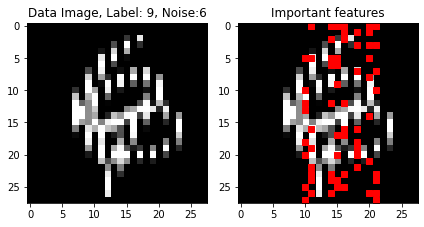

In [214]:
visualize_attack(cols, r, test_img, 9, 6)